In [165]:
import os 
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Import sim functions
from neurodsp.sim import (sim_oscillation, sim_bursty_oscillation, sim_variable_oscillation, sim_damped_oscillation)
from neurodsp.utils import set_random_seed

from neurodsp.sim.combined import sim_combined, sim_peak_oscillation
from neurodsp.sim.aperiodic import sim_powerlaw

# Import function to compute power spectra
from neurodsp.spectral import compute_spectrum

# Import utilities for plotting data
from neurodsp.utils import create_times
from neurodsp.plts.spectral import plot_power_spectra
from neurodsp.plts.time_series import plot_time_series

In [166]:
# Set the random seed, for consistency simulating data
set_random_seed(0)

# Simulation settings
num_signals = 10000
fs = 2000 #sampling 주파수
n_seconds = 2 #simulation 지속시간
times = create_times(n_seconds, fs) #시간 백터

# Generate artifact
amplitude_range = (10, 20)   # range for amplitude_range
amplitude = np.random.uniform(amplitude_range[0], amplitude_range[1])
frequency = 130
period = 1 / frequency
num_cycles = int(np.ceil(times[-1] / period))
samples_per_period = int(fs * period) +1

# 초기 (0, 4000) 크기의 빈 numpy 배열 생성
set_shape_2d = np.zeros((0, len(times)))
# 초기 (1000, 4000) 크기의 빈 numpy 배열 생성
set_shape_2d_2 = np.zeros((num_signals, len(times)))
# 초기 (4000, ) 크기의 빈 numpy 배열 생성
set_shape_1d = np.zeros(len(times))

# -------- < original signal data > ------------------------------------------------

data_signal = set_shape_2d.copy()

# -------- < artifact data - type > ------------------------------------------------

data_sine = set_shape_2d.copy()
data_non_sine_v1 = set_shape_2d.copy()
data_non_sine_v2 = set_shape_2d.copy()

# -------- < artifact data - varying > ------------------------------------------------

data_varying = set_shape_2d_2.copy()

# -------- < synthesized data > ------------------------------------------------

data_with_non_sine_v2_varying = set_shape_2d.copy()

Text(0.5, 1.0, 'data_signal')

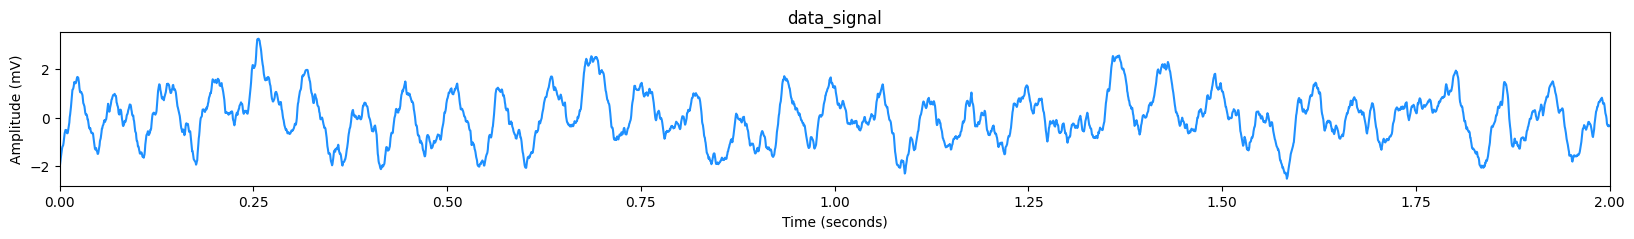

In [167]:
################ clean data 통일
fpath = "C:/Users/stell/UGRP_Github_desktop/UGRP/data/synthetic_data/"

data_signal = np.load(fpath + "clean_data_paper" + ".npy")
data_signal = data_signal[0:num_signals, :]

plt.figure(figsize=(20, 2))

plt.plot(times, data_signal[0, :], label = 'data signal', c='dodgerblue')
plt.xlim([0, 2])
plt.ylabel("Amplitude (mV)")
plt.xlabel("Time (seconds)")
plt.title('data_signal')

In [168]:
# ------------------------------------<< non-sinusoidal oscillation >>------------------------------------------------------------------------------------------
# Define settings
rdsym = 0.2

# Simulate a non-sinusoidal oscillation
# osc_shape = sim_oscillation(n_seconds, fs, frequency, cycle='asine', rdsym=rdsym)

for idx in range(num_signals):
    # Generate a 130 Hz sine wave
    osc_shape = sim_oscillation(n_seconds, fs, frequency, cycle='asine', rdsym=rdsym)

    data_non_sine_v1 = np.vstack((data_non_sine_v1, osc_shape))
    
print("data_non_sine_v1 shape:", data_non_sine_v1.shape) # (10000, 4000)

KeyboardInterrupt: 

In [ ]:
# negative 영역 확장
neg_part = set_shape_1d.copy()
neg_parts = set_shape_2d.copy()

# positive 영역 유지
pos_part = set_shape_1d.copy()
pos_parts = set_shape_2d.copy()
neg_parts_hang = set_shape_2d_2.copy()

# negative/positive 영역 분리
for idx in range(num_signals):
    neg_part = np.where(data_non_sine_v1[idx, :] < 0, data_non_sine_v1[idx, :], 0)
    neg_parts = np.vstack((neg_parts, neg_part))

neg_parts = neg_parts * 2.5

for idx in range(num_signals):
    pos_part = np.where(data_non_sine_v1[idx, :] > 0, data_non_sine_v1[idx, :], 0)
    pos_parts = np.vstack((pos_parts, pos_part))

# data_non_sine_v2 생성
data_non_sine_v2 = pos_parts + neg_parts

print("data_non_sine_v2 shape:", data_non_sine_v2.shape) # (10000, 4000)

data_non_sine_v2 shape: (10, 4000)


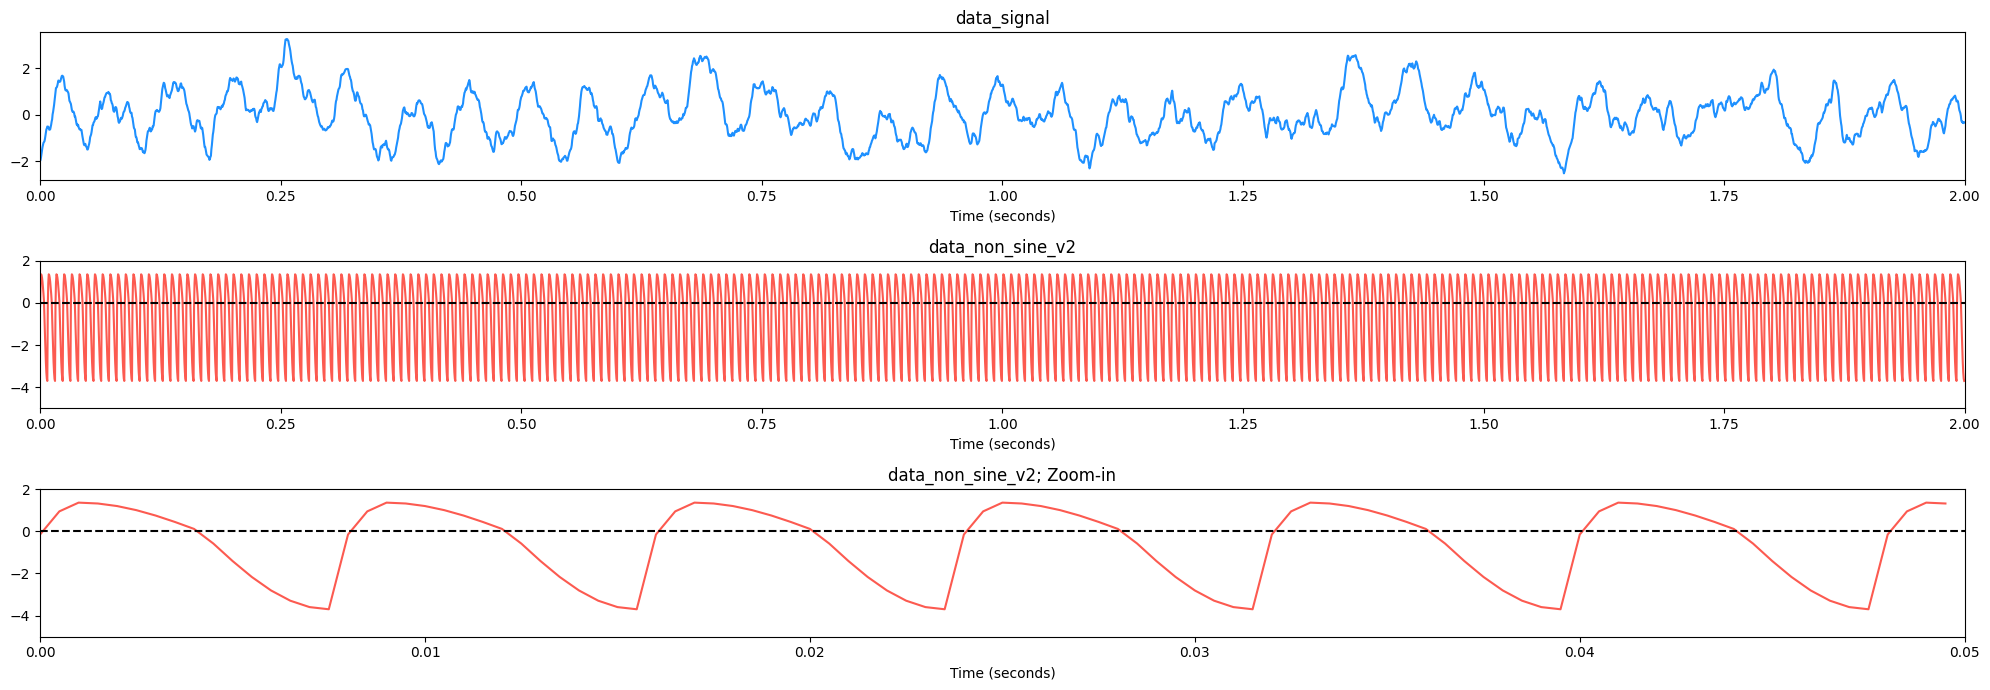

In [ ]:
plt.figure(figsize=(20, 7))

plt.subplot(3, 1, 1)
plt.plot(times, data_signal[0, :], c='dodgerblue')
plt.xlim([0, 2])
plt.xlabel("Time (seconds)")
plt.title('data_signal')

plt.subplot(3, 1, 2)
plt.plot(times, data_non_sine_v2[0, :], c='xkcd:coral'); plt.gca().set_ylim([-5, 2])
plt.axhline(y=0, color='k', linestyle='--')
plt.xlim([0, 2])
plt.xlabel("Time (seconds)")
plt.title('data_non_sine_v2')

plt.subplot(3, 1, 3)
plt.plot(times[0:100], data_non_sine_v2[0, 0:100], c='xkcd:coral'); plt.gca().set_ylim([-5, 2])
plt.axhline(y=0, color='k', linestyle='--')
plt.xlim([0, 0.05])
plt.xlabel("Time (seconds)")
plt.title('data_non_sine_v2; Zoom-in')

plt.tight_layout()

In [ ]:
# Varying 추가
# random_amplitudes = np.random.uniform(amplitude_range_mean * 5, amplitude_range_mean * 10, num_signals)
random_amplitudes = np.random.uniform(0.75, 1.25, (num_signals, num_cycles))

for idx in range(num_signals):
    for i in range(num_cycles):
        start_idx = i * samples_per_period
        end_idx = min((i + 1) * samples_per_period, len(times))

        if start_idx >= len(times):
            break

        each_period = set_shape_1d.copy()
        each_period[start_idx:end_idx] = random_amplitudes[idx, i] * data_non_sine_v2[idx, start_idx:end_idx]
        data_varying[idx, start_idx:end_idx] += each_period[start_idx:end_idx]
    

data_varying shape: (10, 4000)


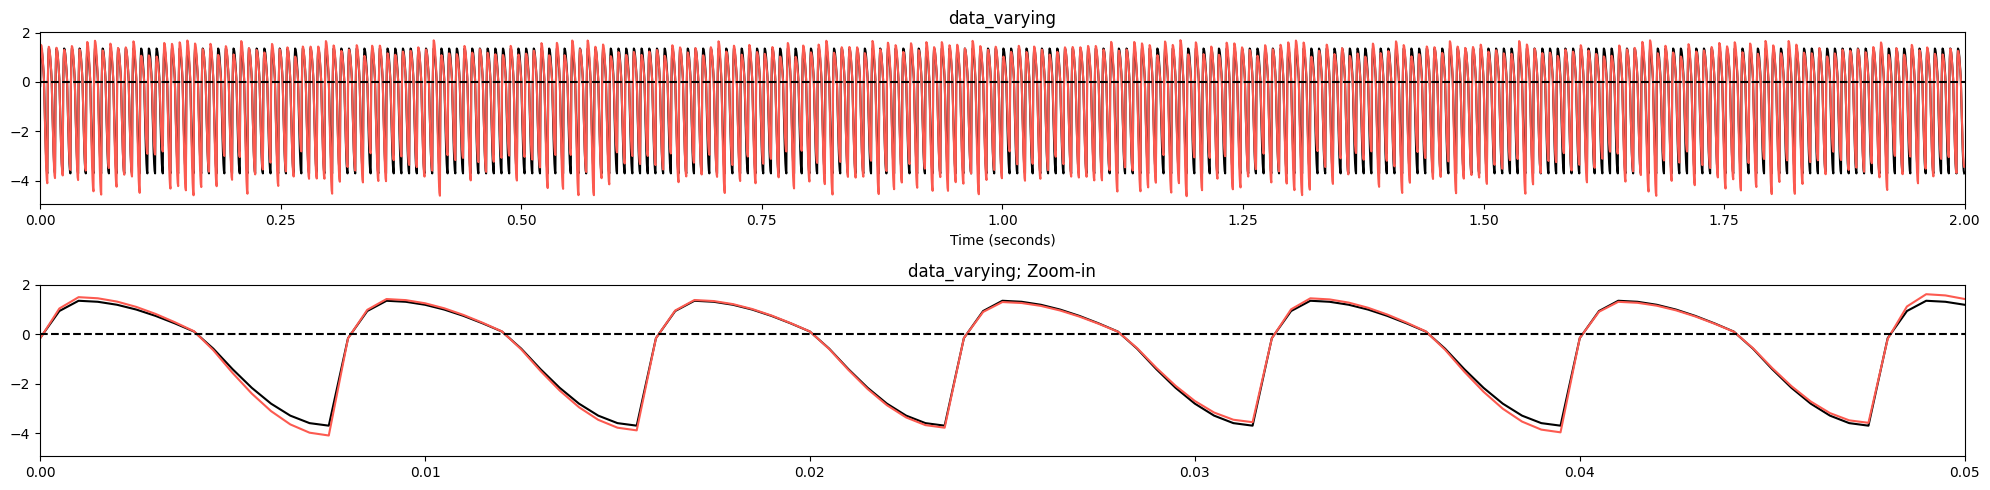

In [ ]:
plt.figure(figsize=(20, 5))

plt.subplot(2, 1, 1)
plt.plot(times, data_non_sine_v2[0, :], c='k')
plt.xlim([0, 2])
plt.xlabel("Time (seconds)")
plt.plot(times, data_varying[0, :], color='xkcd:coral')
plt.axhline(y=0, color='k', linestyle='--')
plt.title('data_varying')

# print(np.count_nonzero(data_varying[1, :] == 0)) # 100
# print(samples_per_period) # 15
# print(num_cycles) # 260 
# 260 * 15 = 3900
plt.subplot(2, 1, 2)
plt.title('data_varying; Zoom-in')
plt.plot(times, data_non_sine_v2[0, :], c='k')
plt.plot(times, data_varying[0, :], color='xkcd:coral')
plt.axhline(y=0, color='k', linestyle='--')
plt.xlim([0, 0.05])

plt.tight_layout()

print('data_varying shape:', data_varying.shape)

In [ ]:
print('<data_signal> min:', np.min(data_signal), 'max:', np.max(data_signal))
print('<data_varying> min:', np.min(data_varying), 'max:', np.max(data_varying))

<data_signal> min: -3.274024410939041 max: 3.2421486743970256
<data_varying> min: -4.623415482397393 max: 1.69282210749097


data_with_non_sine_v2_varying shape: (10, 4000)


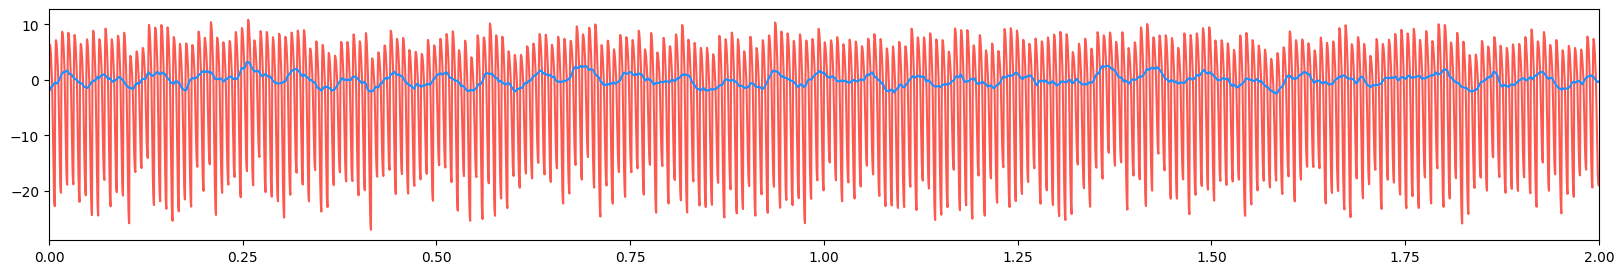

In [ ]:
for i in range(num_signals):
   x = np.min(data_signal[i, :]) * 10 / np.min(data_varying[i, :])
   signal = data_signal[i, :] + data_varying[i, :] * x

   data_with_non_sine_v2_varying = np.vstack((data_with_non_sine_v2_varying, signal)) # (10000, 4000)

plt.figure(figsize=(20, 3))
plt.plot(times, data_with_non_sine_v2_varying[0, :], c='xkcd:coral')
plt.plot(times, data_signal[0, :], c='dodgerblue')
plt.xlim([0, 2])

print('data_with_non_sine_v2_varying shape:', data_with_non_sine_v2_varying.shape)

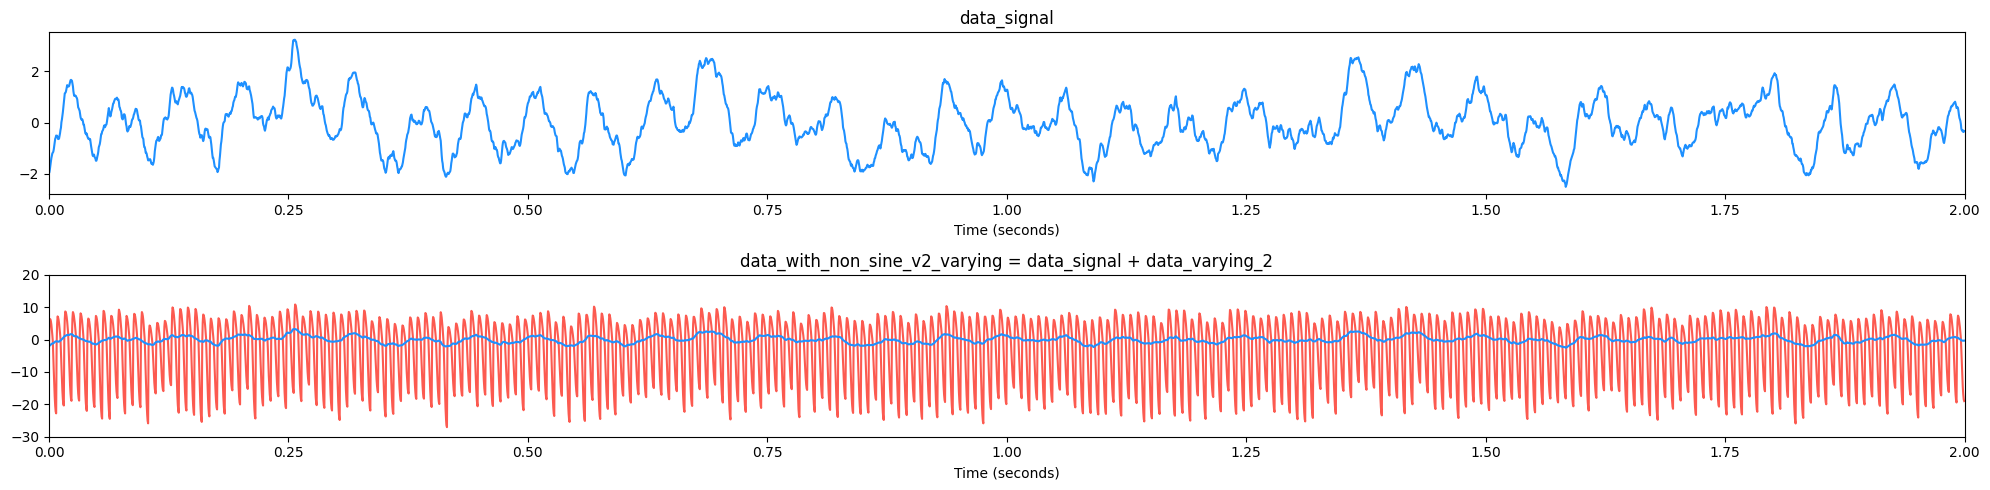

In [ ]:
# 전체 플랏
plt.figure(figsize=(20, 5))

plt.subplot(2, 1, 1)
plt.plot(times, data_signal[0, :], c='dodgerblue')
plt.xlim([0, 2])
plt.xlabel("Time (seconds)")
plt.title('data_signal')

plt.subplot(2, 1, 2)
plt.plot(times, data_with_non_sine_v2_varying[0, :], c='xkcd:coral'); plt.gca().set_ylim([-30, 20])
plt.plot(times, data_signal[0, :], c='dodgerblue')
plt.xlim([0, 2])
plt.xlabel("Time (seconds)")
plt.title('data_with_non_sine_v2_varying = data_signal + data_varying_2')

plt.tight_layout()

In [ ]:
print('<data_varying> min:', np.min(data_varying[5, :]), 'max:', np.max(data_varying[5, :]))
print('<data_signal> min:', np.min(data_signal[5, :]), 'max:', np.max(data_signal[5, :]))

print('<data_with_non_sine_v2_varying> min:', np.min(data_with_non_sine_v2_varying[5, :]), 'max:', np.max(data_with_non_sine_v2_varying[5, :]))

<data_varying> min: -4.620112649186176 max: 1.691612804736634
<data_signal> min: -3.274024410939041 max: 2.7766644506934965
<data_with_non_sine_v2_varying> min: -34.010137290309366 max: 14.002469592114448


In [ ]:
# -------- < 저장 > ------------------------------------------------
# -------- < synthesized data > ------------------------------------------------

# np.save(fpath + "contaminated_by_realistic_paper" + ".npy", data_with_non_sine_v2_varying)